# Different noise model

In [1]:
import sys
import os
sys.path.append(os.path.abspath(".."))

import matplotlib.pyplot as plt
from sklearn.svm import LinearSVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from util.create_artificial_dataset import create_artificial_dataset, corrupt_sln, corrupt_ccn, corrupt_iln

from constants.visualization_defaults import FIG_SIZE, FONT_SIZE_PARAMS

plt.rcParams.update(FONT_SIZE_PARAMS) 

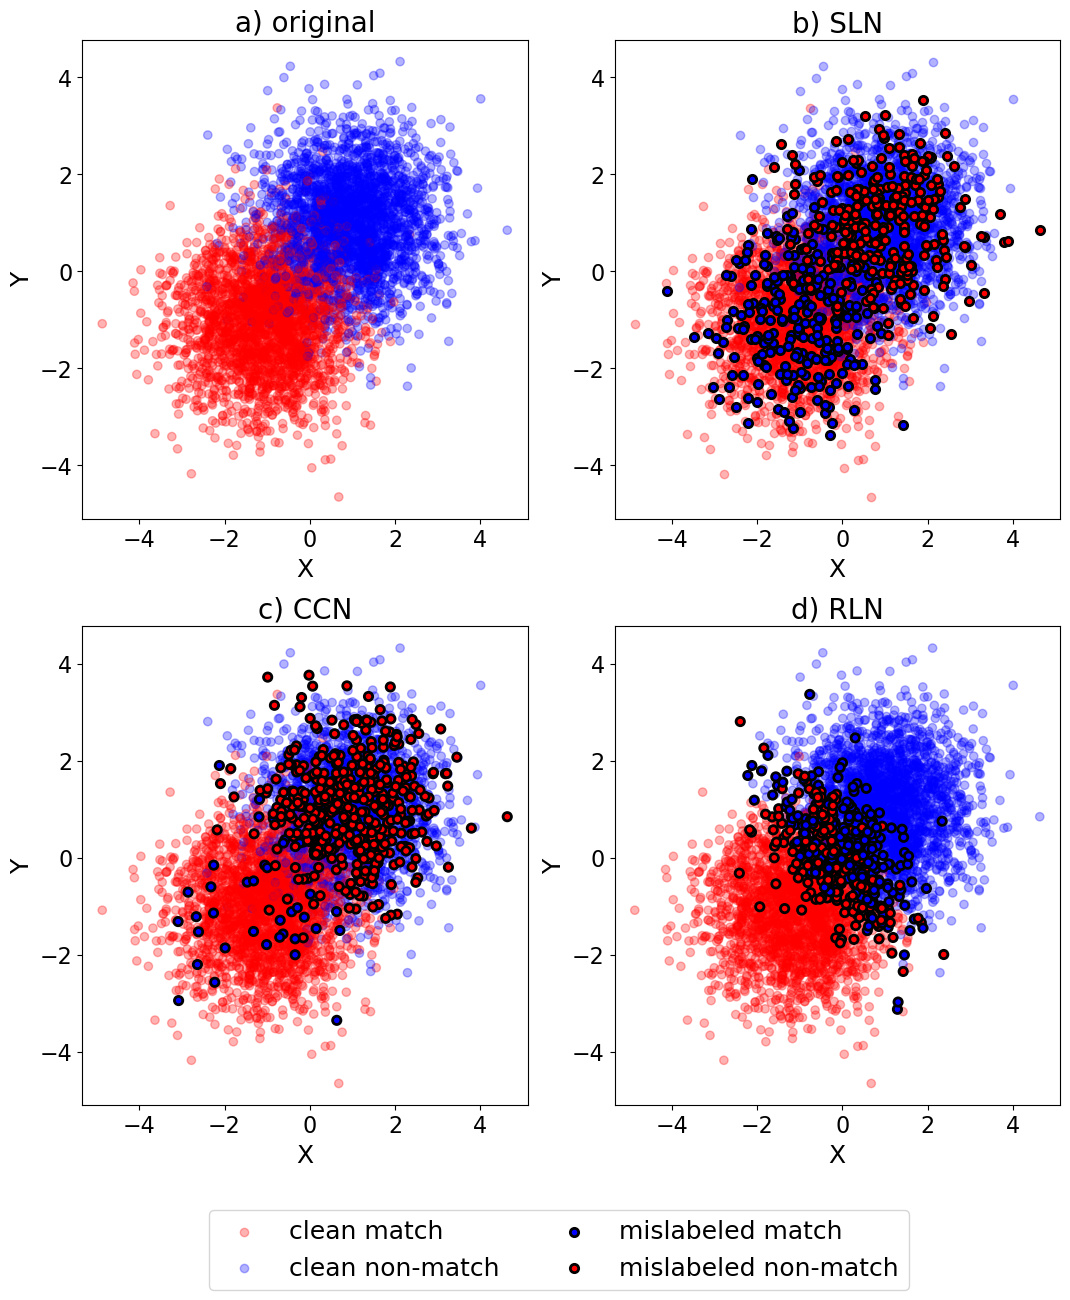

In [17]:
df = create_artificial_dataset()
df = df.sample(frac=1).reset_index(drop=True)

fig, axs = plt.subplots(2, 2, figsize=(12, 12))

sln_corrupted_data = corrupt_sln(df, noise_rate=0.1)
sln_clean_matches = sln_corrupted_data[(sln_corrupted_data["label"] == 1) & (sln_corrupted_data["noisy_label"] == 1)]
sln_clean_non_matches = sln_corrupted_data[(sln_corrupted_data["label"] == 0) & (sln_corrupted_data["noisy_label"] == 0)]
sln_mislabeled_matches = sln_corrupted_data[(sln_corrupted_data["label"] == 1) & (sln_corrupted_data["noisy_label"] == 0)]
sln_mislabeled_non_matches = sln_corrupted_data[(sln_corrupted_data["label"] == 0) & (sln_corrupted_data["noisy_label"] == 1)]

ccn_corrupted_data = corrupt_ccn(df, alpha=0.18, beta=0.015)
mislabeled_ccn_corrupted = ccn_corrupted_data[ccn_corrupted_data["label"] != ccn_corrupted_data["noisy_label"]]

iln_corrupted_data1 = corrupt_iln(df, teacher_model=RandomForestClassifier(), dataset='artificial')
mislabeled_iln = iln_corrupted_data1[iln_corrupted_data1["label"] != iln_corrupted_data1["noisy_label"]]

axs[0][0].scatter(df["x1"], df["x2"], c=df["label"], cmap='bwr', alpha=0.3)
axs[0][0].set_title('a) original')
axs[0][0].set_xlabel('X')
axs[0][0].set_ylabel('Y')

axs[0][1].scatter(sln_clean_matches["x1"], sln_clean_matches["x2"], alpha=0.3, color="red", label="clean match")
axs[0][1].scatter(sln_clean_non_matches["x1"], sln_clean_non_matches["x2"], alpha=0.3, color="blue", label="clean non-match")
axs[0][1].scatter(sln_mislabeled_matches["x1"], sln_mislabeled_matches["x2"], alpha=1, color="blue", edgecolors="black", linewidths=2, label="mislabeled match")
axs[0][1].scatter(sln_mislabeled_non_matches["x1"], sln_mislabeled_non_matches["x2"], alpha=1, color="red", edgecolors="black", linewidths=2, label="mislabeled non-match")
axs[0][1].set_title('b) SLN')
axs[0][1].set_xlabel('X')
axs[0][1].set_ylabel('Y')

axs[1][0].scatter(ccn_corrupted_data["x1"], ccn_corrupted_data["x2"], alpha=0.3, c=ccn_corrupted_data["label"], cmap='bwr')
axs[1][0].scatter(mislabeled_ccn_corrupted["x1"], mislabeled_ccn_corrupted["x2"], alpha=1, c=mislabeled_ccn_corrupted["noisy_label"], cmap='bwr', edgecolors='black', linewidths=2)
axs[1][0].set_title('c) CCN')
axs[1][0].set_xlabel('X')
axs[1][0].set_ylabel('Y')

axs[1][1].scatter(iln_corrupted_data1["x1"], iln_corrupted_data1["x2"], alpha=0.3, c=iln_corrupted_data1["label"], cmap='bwr')
axs[1][1].scatter(mislabeled_iln["x1"], mislabeled_iln["x2"], alpha=1, c=mislabeled_iln["noisy_label"], cmap='bwr', edgecolors='black', linewidths=2)
axs[1][1].set_title('d) RLN')
axs[1][1].set_xlabel('X')
axs[1][1].set_ylabel('Y')

handles = []
all_labels = []

axs = axs.flatten()

for i, ax in enumerate(axs):

    h, l = ax.get_legend_handles_labels()
    handles.extend(h)
    all_labels.extend(l)
    if i == 1:
        break

fig.legend(handles, all_labels, loc='lower center', bbox_to_anchor=(0.57, -0.1),
           ncol=2)

plt.tight_layout(rect=[0.1, 0, 1, 0.99])  
plt.show()



# Transitions

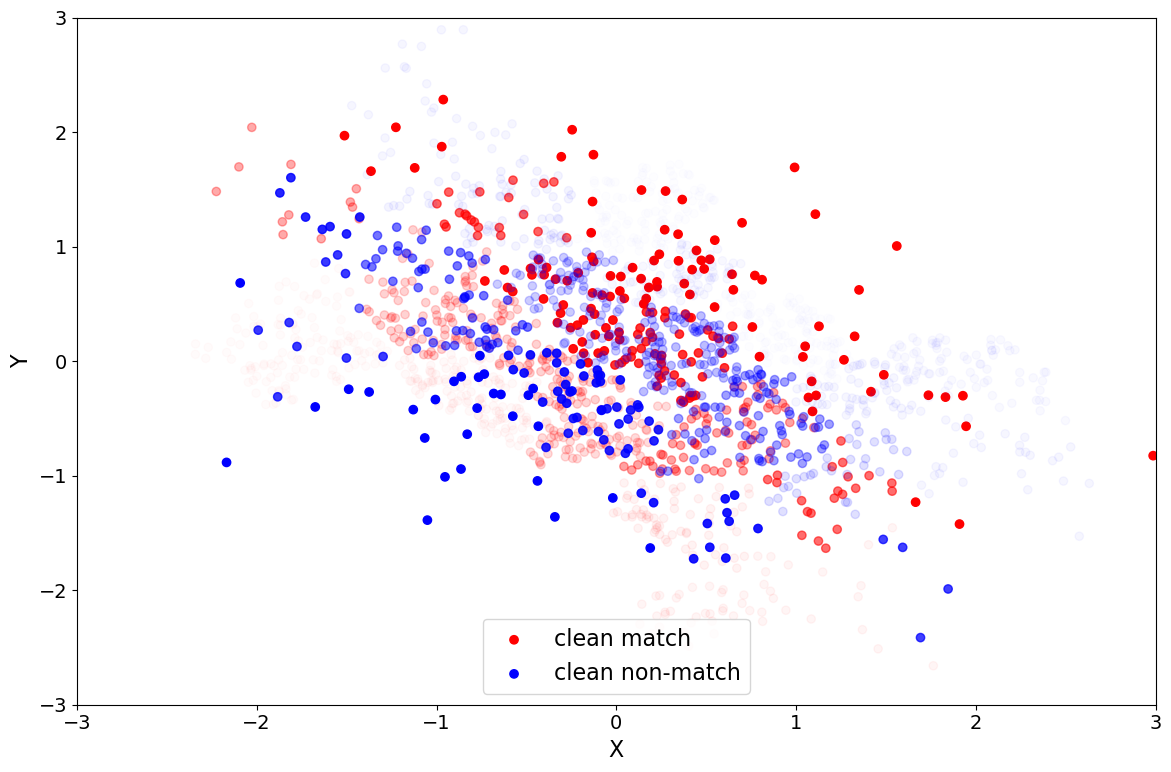

In [15]:
iln_corrupted_data_random_forest = corrupt_iln(df, teacher_model=RandomForestClassifier(), dataset='artificial')

plt.figure(figsize=(12, 8))

matches = iln_corrupted_data_random_forest[iln_corrupted_data_random_forest["label"] == 1].sort_values("mislabeling_probability", ascending=False)
non_matches = iln_corrupted_data_random_forest[iln_corrupted_data_random_forest["label"] == 0].sort_values("mislabeling_probability", ascending=False)

plt.scatter(matches["x1"], 
            matches["x2"], 
            alpha=matches["mislabeling_probability"], 
            color="red",
            label="clean match")

plt.scatter(non_matches["x1"], 
            non_matches["x2"], 
            alpha=non_matches["mislabeling_probability"], 
            color='blue',
            label="clean non-match")

plt.xlim(-3, 3)
plt.ylim(-3, 3)

plt.xlabel("X")
plt.ylabel("Y")

plt.legend(loc='lower center')

plt.tight_layout()
plt.show()

# empirical CDFs

In [4]:
from sklearn.ensemble import RandomForestClassifier
import pandas as pd
from util.create_artificial_dataset import create_artificial_dataset, corrupt_iln
import numpy as np

In [5]:
number_of_instances_artificial_dataset = 102400

artificial_data = create_artificial_dataset(round(number_of_instances_artificial_dataset / 2), round(number_of_instances_artificial_dataset / 2))
music = pd.read_csv('../../datasets/music/preprocessed_music_most_values.csv')
wdc_almser = pd.read_csv('../../datasets/wdc_almser/preprocessed_wdc_almser_most_values.csv')
dexter = pd.read_csv('../../datasets/dexter/preprocessed_dexter.csv')

teacher =  RandomForestClassifier()

corrupted_iln_artificial = corrupt_iln(artificial_data, teacher, "artificial")[["label", "mislabeling_probability"]]
corrupted_music = corrupt_iln(music, teacher, "music_most_values")[["label", "mislabeling_probability"]]
corrupted_wdc_almser = corrupt_iln(wdc_almser, teacher, "wdc_almser_most_values")[["label", "mislabeling_probability"]]
corrupted_dexter = corrupt_iln(dexter, teacher, "dexter")[["label", "mislabeling_probability"]]

In [6]:
iln_artificial_matches = corrupted_iln_artificial[corrupted_iln_artificial["label"] == 1]
iln_music_matches = corrupted_music[corrupted_music["label"] == 1]
iln_wdc_almser_matches = corrupted_wdc_almser[corrupted_wdc_almser["label"] == 1]
iln_dexter_matches = corrupted_dexter[corrupted_dexter["label"] == 1]

iln_artificial_non_matches = corrupted_iln_artificial[corrupted_iln_artificial["label"] == 0]
iln_music_non_matches = corrupted_music[corrupted_music["label"] == 0]
iln_wdc_almser_non_matches = corrupted_wdc_almser[corrupted_wdc_almser["label"] == 0]
iln_dexter_non_matches = corrupted_dexter[corrupted_dexter["label"] == 0]


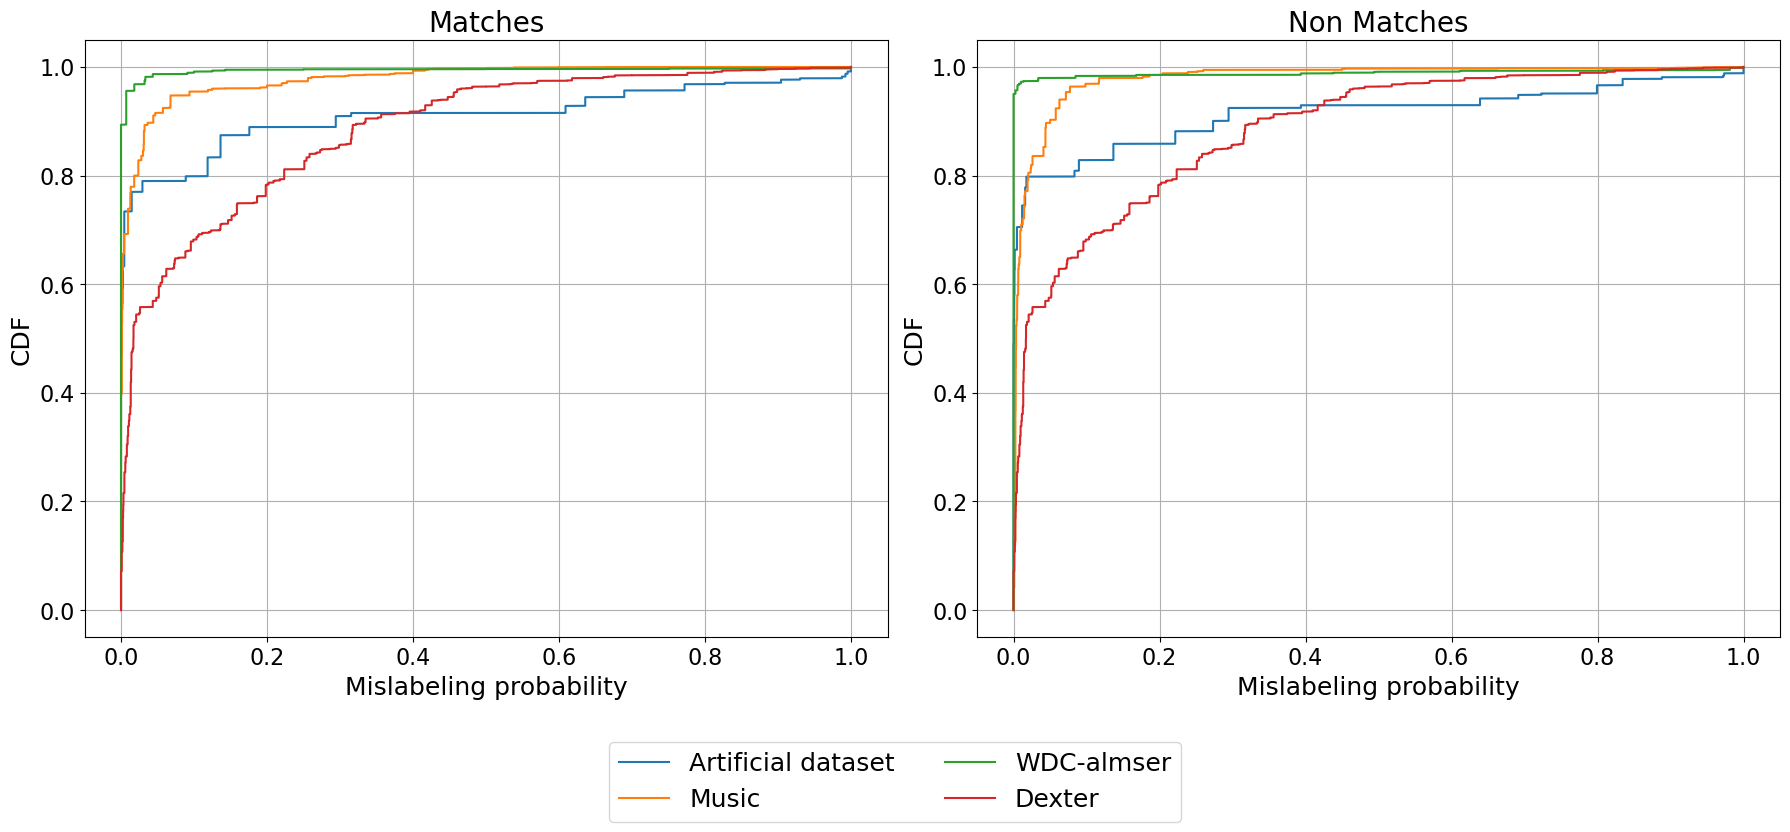

In [8]:
fig, ax = plt.subplots(1, 2, figsize=FIG_SIZE)

x_artificial_matches = np.sort(iln_artificial_matches["mislabeling_probability"])
y_artificial_matches = np.arange(1, len(x_artificial_matches)+1) / len(x_artificial_matches)

x_music_matches = np.sort(iln_music_matches["mislabeling_probability"])
y_music_matches = np.arange(1, len(x_music_matches)+1) / len(x_music_matches)

x_wdc_almser_matches = np.sort(iln_wdc_almser_matches["mislabeling_probability"])
y_wdc_almser_matches = np.arange(1, len(x_wdc_almser_matches)+1) / len(x_wdc_almser_matches)

x_dexter_matches = np.sort(iln_dexter_matches["mislabeling_probability"])
y_dexter_matches = np.arange(1, len(x_dexter_matches)+1) / len(x_dexter_matches)

x_artificial_non_matches = np.sort(iln_artificial_non_matches["mislabeling_probability"])
y_artificial_non_matches = np.arange(1, len(x_artificial_non_matches)+1) / len(x_artificial_non_matches)

x_music_non_matches = np.sort(iln_music_non_matches["mislabeling_probability"])
y_music_non_matches = np.arange(1, len(x_music_non_matches)+1) / len(x_music_non_matches)

x_wdc_almser_non_matches = np.sort(iln_wdc_almser_non_matches["mislabeling_probability"])
y_wdc_almser_non_matches = np.arange(1, len(x_wdc_almser_non_matches)+1) / len(x_wdc_almser_non_matches)

x_dexter_non_matches = np.sort(iln_dexter_non_matches["mislabeling_probability"])
y_dexter_non_matches = np.arange(1, len(x_dexter_non_matches)+1) / len(x_dexter_non_matches)

l1 = ax[0].plot(x_artificial_matches, y_artificial_matches, label='Artificial dataset')
l2 = ax[0].plot(x_music_matches, y_music_matches, label='Music')
l3 = ax[0].plot(x_wdc_almser_matches, y_wdc_almser_matches, label='WDC-almser')
l4 = ax[0].plot(x_dexter_matches, y_dexter_matches, label='Dexter')
ax[0].set_xlabel('Mislabeling probability')
ax[0].set_ylabel('CDF')
ax[0].set_title('Matches')
ax[0].grid()

l1 = ax[1].plot(x_artificial_non_matches, y_artificial_non_matches, label='Artificial dataset')
l2 = ax[1].plot(x_music_non_matches, y_music_non_matches, label='Music')
l3 = ax[1].plot(x_wdc_almser_non_matches, y_wdc_almser_non_matches, label='WDC-almser')
l4 = ax[1].plot(x_dexter_matches, y_dexter_matches, label='Dexter')
ax[1].set_xlabel('Mislabeling probability')
ax[1].set_ylabel('CDF')
ax[1].set_title('Non Matches')
ax[1].grid()

handles, labels = ax[1].get_legend_handles_labels()
fig.legend(handles, labels, loc='lower center', ncol=2, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout(rect=[0, 0.05, 1, 0.95])  
plt.show()
